In [ ]:
import os
from loaddatastructs import *
import matplotlib
from scipy.ndimage.filters import gaussian_filter
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from nsh import montecarlospatialhet # see note below on compilation

## README

Before running this notebook, compile the `nsh` module using the `compile_nsh.sh` script.

In [2]:
data_path = os.path.join(os.getcwd(), '..', 'data')

# Domain wide quantities at t=36
Cat1 = DataStruct()
Cat1.archive_path = f'{data_path}/processed_data'

# Number and mass distributions at t=36, z=60
Cat2 = DataStruct()
Cat2.archive_path = f'{data_path}/processed_data'

# cross-section average CCN concentrations (all t, all z)
Cat3 = DataStruct()
Cat3.archive_path = f'{data_path}/processed_data'

for i in range(4):
    if i == 0:
        scenario = 'uniform-basecase'
    else:
        scenario = f'scenario-{i}'
    Cat1.addScenario(scenario_name=scenario, 
                                aero_data_filename=f'{scenario}_subset_t36.nc',
                                load_aerodist_data=False,
                                load_wrf_data=False, 
                                historydelta_m=10)
    Cat2.addScenario(scenario_name=scenario,
                    load_aero_data=False, 
                    aero_dist_filename=f'{scenario}_size-dist_subset_t0_t36_z60.nc', 
                    load_wrf_data=False, 
                    historydelta_m=10)
    Cat3.addScenario(scenario_name=scenario,
                     aero_data_filename=f'{scenario}_ccn-vars_subset.nc',
                     load_aerodist_data=False,
                     load_wrf_data=False,
                     historydelta_m=10)
    
# Add NH4 free scenarios
scenario = 'uniform-basecase-no-nh4'
Cat1.addScenario(scenario_name=scenario, 
                                aero_data_filename=f'{scenario}_subset_t36.nc',
                                load_aerodist_data=False,
                                load_wrf_data=False, 
                                historydelta_m=10)
scenario = 'scenario-3-no-nh4'
Cat1.addScenario(scenario_name=scenario, 
                                aero_data_filename=f'{scenario}_subset_t36.nc',
                                load_aerodist_data=False,
                                load_wrf_data=False, 
                                historydelta_m=10)

..using uniform-basecase as basecase for simulation attributes
....n_times: 1
....n_levels: 100
....domain_x_cells: 100
....domain_y_cells: 100
....historydelta_m: 10
..using uniform-basecase as basecase for simulation attributes
....n_times: 2
....n_levels: 1
....domain_x_cells: 100
....domain_y_cells: 100
....historydelta_m: 10
..using uniform-basecase as basecase for simulation attributes
....n_times: 37
....n_levels: 100
....domain_x_cells: 1
....domain_y_cells: 1
....historydelta_m: 10


#### SNA Profiles

In [3]:
def plotScenariosVarsVerticalProfile(DataStruct, scenarios, variables, time, **kwargs):
    global_fontsize = kwargs.get('global_fontsize', 13)
    if (len(variables) < 4):
        fig_xsize = kwargs.get('fig_xsize', len(variables)*4)
        fig_ysize = kwargs.get('fig_ysize', 4.5)
        fig, axs  = plt.subplots(1,len(variables), figsize=(fig_xsize,fig_ysize))

    if (len(variables) == 4):
        fig_xsize = kwargs.get('fig_xsize', 2*4)
        fig_ysize = kwargs.get('fig_ysize', 8.5)
        fig, axs  = plt.subplots(2, 2, figsize=(fig_xsize,fig_ysize))

    if (len(variables) > 4) and (len(variables) < 7):
        fig_xsize = kwargs.get('fig_xsize', 3*4)
        fig_ysize = kwargs.get('fig_ysize', 8.5)
        fig, axs  = plt.subplots(2, 3, figsize=(fig_xsize,fig_ysize))
        if len(variables)<6:
            axes_to_remove = 6-len(variables)
            for i in range(axes_to_remove):
                i+=1
                axs[-1*i].remove()

    if kwargs.get('general_scenario_label'):
        labels= DataStruct.getScenarioGeneralLabels()
    if kwargs.get('use_standard_scenario_colors'):
        colors = DataStruct.getScenarioColors()
    else:
        set1 = plt.get_cmap(kwargs.get('cmap', 'Set1'))
        num_colors = set1.N # number of colors in the set1 colormap
        colors = {}
        # Extract colors and convert to hex
        for i, scenario in enumerate(scenarios): # alternatively loop over range num_colors
            rgba = set1(i)  # Get RGBA values
            hex_color = mplcolors.to_hex(rgba)  # Convert RGBA to hex
            colors[scenario] = hex_color

    vars_to_quantile = kwargs.get('vars_to_quantile', {})

    # for processed datasets which contain a slice of the original dataset
    if (DataStruct.n_times == 1) and time > 0:
        time_idx = 0
    else:
        time_idx = time

    for i, (ax, variable) in enumerate(zip(axs.flatten(), variables)):
        write_quantile=True
        for scenario in scenarios:
            #times = np.arange(DataStruct.n_times)
            var_array = np.zeros((DataStruct.n_times))
            variable_fmt = variable
            if variable in DataStruct.aero_vars:
                if variable.startswith('ccn') or 'NUM_CONC' in variable:
                    # number concentration to number per kg of air
                    inverse_airdens = DataStruct.aero_data[scenario]['ALT'][time_idx, :, :, :]
                    array = inverse_airdens*DataStruct.aero_data[scenario][variable][time_idx, :, :, :]
                    var_units = '# kg$^{-1}$'
                    if kwargs.get('unit_prefactor'):
                        unit_prefactor = kwargs.get('unit_prefactor')
                        array = unit_prefactor*inverse_airdens*DataStruct.aero_data[scenario][variable][time_idx, :, :, :]
                        unit_prefactor_str = f'{1/unit_prefactor:1.0e}'
                        components = unit_prefactor_str.split('e')
                        signif = components[0]
                        expon = components[1].replace('+', '').lstrip("0")
                        fmt_unit_prefac = '$' + signif + '\\times' + '10^{' + expon + '}' + '$'

                        var_units = '(# kg$^{-1}$)$/$' + fmt_unit_prefac

                elif variable.startswith('pmc'):
                    # convert to mixing ratio
                    inverse_airdens = DataStruct.aero_data[scenario]['ALT'][time_idx, :, :, :]
                    array = 1e9*inverse_airdens*DataStruct.aero_data[scenario][variable][time_idx, :, :, :]
                    var_units = 'Mixing Ratio (ppbv)'

                else:
                    array = DataStruct.aero_data[scenario][variable][time_idx, :, :, :]
                    var_units = ''
                variable_fmt = DataStruct.aerosol_fmt_map[variable]
            elif variable in DataStruct.gas_vars:
                if variable == 'oh':
                    scaling_factor = 1e6 # scale to pptv
                    var_units = 'Mixing Ratio (pptv)'
                else:
                    scaling_factor = 1e3
                    var_units = 'Mixing Ratio (ppbv)'
                array = scaling_factor*DataStruct.aero_data[scenario][variable][time_idx, :, :, :] # convert ppmv to ppbv
                
                variable_fmt = DataStruct.gas_fmt_map[variable]
            elif variable in DataStruct.wrf_vars:
                array = DataStruct.aero_data[scenario][variable][time_idx, :, :, :]
                var_units = ''
            else:
                raise AttributeError(f'Variable {variable} not recognized')
            
            if variable in vars_to_quantile.keys():
                quantile = vars_to_quantile[variable]
                array_mean = np.quantile(array, quantile, axis=(1,2))
                if write_quantile:
                    ax.text(.5, .87, f'{quantile} quantile', transform=ax.transAxes, fontsize=global_fontsize, horizontalalignment='center', 
                            bbox=dict(facecolor='white', edgecolor='black', alpha=.8))
                    write_quantile = False
            else:
                array_mean = array.mean(axis=(1,2))

            if kwargs.get('general_scenario_label'):
                label = labels[scenario]
            else:
                label = scenario
            
            color = colors[scenario]
            ls = '-'
            if 'no-nh4' in scenario:
                ls = '--'
            ax.plot(array_mean, np.arange(100), label=label, c=color, ls=ls)
            #if kwargs.get('plot_std'):
            #    array_std = array.std(axis=(1,2))
            #    ax.fill_betweenx(np.arange(100), array_mean-array_std, array_mean+array_std, alpha=.4)

        #cbar = fig.colorbar(cs, label=f'{variable} {var_units}')
        legend_cols = kwargs.get('legend_ncols', len(scenarios))
        if len(variables) > 1:
            if i == 0:
                fig.legend(fontsize=global_fontsize, ncol=legend_cols, loc='center', bbox_to_anchor=(.5,-.05))
        else:
            ax.legend(fontsize=global_fontsize)
        ax.set_xlabel(f'{var_units}', fontsize=global_fontsize)
        ax.set_ylabel('z (km)', fontsize=global_fontsize)
        ax.set_yticks(np.arange(0, DataStruct.n_levels+1, 25))
        ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
        ax.set_title(f'{variable_fmt}', fontsize=global_fontsize)

        ax.set_ylim(0, DataStruct.n_levels)
        if kwargs.get('grid', True):
            lw = kwargs.get('grid_linewidth', 1)
            ax.grid(which = "major", linewidth = lw, axis='y', ls="dotted", dashes=(.5,6), c='#414141', alpha=.5)
            ax.grid(which = "minor", linewidth = lw, axis='y', ls="dotted", dashes=(.5,6), c='white')
            ax.grid(which = "minor", linewidth = lw, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
            ax.grid(which = "major", linewidth = lw, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
            ax.tick_params(axis='both', labelsize=global_fontsize, which='major', direction='in', top=True, right=True, bottom=True, left=True)
            ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    delta_t = DataStruct.historydelta_m
    plt.suptitle(kwargs.get('title', f'Time: {delta_t*time} m'))
    plt.tight_layout()

    if kwargs.get("savefig"):
        filename = kwargs.get('filename', f'vertical-profiles-time{time}.pdf')
        plt.savefig(filename, format='pdf', bbox_inches='tight')

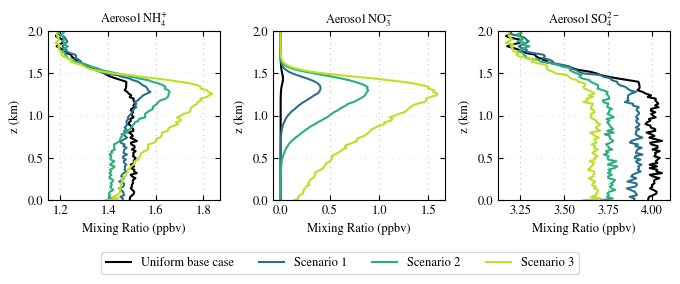

In [4]:
t = 36
plotScenariosVarsVerticalProfile(DataStruct=Cat1, 
                                 scenarios=['uniform-basecase', 'scenario-1', 'scenario-2', 'scenario-3'], 
                                 variables=['pmc_NH4', 'pmc_NO3', 'pmc_SO4'], 
                                 time=t, 
                                 general_scenario_label=True,
                                 use_standard_scenario_colors=True,
                                 title='',
                                 fig_xsize=6.9, fig_ysize=2.7,
                                 global_fontsize=9,
                                 grid_linewidth=0.6,
                                 savefig=False,
                                 filename=f'aerosol-SNA-vertical-profiles-time{t}.pdf'
                                 )

/Users/sf20/opt/anaconda3/envs/paper_env/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


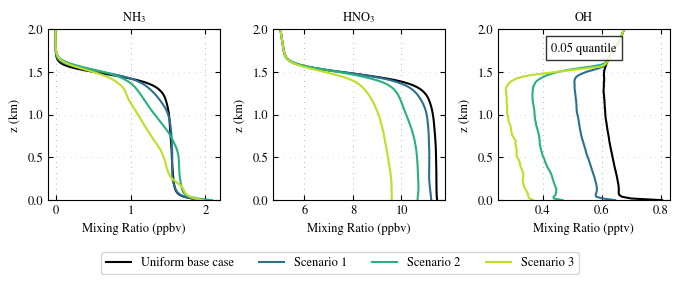

In [5]:
t = 36
plotScenariosVarsVerticalProfile(DataStruct=Cat1, 
                                 scenarios=['uniform-basecase', 'scenario-1', 'scenario-2', 'scenario-3'], 
                                 variables=['nh3', 'hno3', 'oh' ], 
                                 time=t, 
                                 general_scenario_label=True,
                                 use_standard_scenario_colors=True,
                                 title='',
                                 fig_xsize=6.9, fig_ysize=2.7,
                                 global_fontsize=9,
                                 grid_linewidth=0.6,
                                 vars_to_quantile={'oh': 0.05},
                                 savefig=False,
                                 filename=f'aerosol-gas-vertical-profiles-time{t}.pdf'
                                 )

#### Cross section of gas phase species

In [6]:
def plotCrossSections(DataStruct, scenarios, variables, time, z, var_type='gas', savefig=False, **kwargs):

    # for processed datasets which contain a slice of the original dataset
    if (DataStruct.n_times == 1) and time > 0:
        time_idx = 0
    else:
        time_idx = time

    variable_mins = {var: np.nan for var in variables}
    variable_maxs = {var: np.nan for var in variables}
    for j, scenario in enumerate(scenarios):
        scenario_data = Cat1.aero_data[scenario]
        for i, variable in enumerate(variables):

            if var_type == 'gas':
                # convert ppmv to ppbv
                variable_data = 1e3*scenario_data[variable][time_idx, z, :, :]
            if var_type == 'aero':
                # convert to mixing ratio (ppbv)
                inverse_airdens = scenario_data['ALT'][time_idx, z, :, :]
                variable_data = scenario_data[variable][time_idx, z, :, :]
                variable_data = 1e9*inverse_airdens*variable_data

            variable_min = variable_mins[variable]
            variable_max = variable_maxs[variable]

            if (np.isnan(variable_min)) or (variable_data.min() < variable_min):
                variable_mins[variable] = variable_data.min()
                

            if (np.isnan(variable_max)) or (variable_data.max() > variable_max):
                variable_maxs[variable] = variable_data.max()
    
    #print('min', variable_mins)
    #print('max', variable_maxs)

    # set global min and max
    vmin = kwargs.get('vmin', min(variable_mins.values()))
    vmax = kwargs.get('vmax', max(variable_maxs.values()))

    fig, axs = plt.subplots(4, 3, figsize=(6, 7), sharex=True, sharey=True)
    scenario_general_labels = Cat1.getScenarioGeneralLabels()
    for j, scenario in enumerate(scenarios):

        scenario_data = Cat1.aero_data[scenario]
        for i, variable in enumerate(variables):
            if var_type == 'gas':
                # convert ppmv to ppbv
                variable_data = 1e3*scenario_data[variable][time_idx, z, :, :]
            if var_type == 'aero':
                # convert to mixing ratio (ppbv)
                inverse_airdens = scenario_data['ALT'][time_idx, z, :, :]
                variable_data = scenario_data[variable][time_idx, z, :, :]
                variable_data = 1e9*inverse_airdens*variable_data
            ax = axs[j, i]

            norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
            c = ax.pcolormesh(variable_data, norm=norm, #vmin=vmin, vmax=vmax, 
                        cmap='jet',edgecolor='face')

            if scenario == 'uniform-basecase':
                if var_type == 'gas':
                    title = Cat1.gas_fmt_map[variable]
                if var_type == 'aero':
                    title = Cat1.aerosol_fmt_map[variable]
                ax.set_title(title, fontsize=9)
            if i == 0:
                ax.text(-0.4, 0.5, scenario_general_labels[scenario], fontsize=9, transform=ax.transAxes, rotation=90, verticalalignment='center')

            ax.set_aspect('equal')
            nx, ny, xwidth, ywidth = 100, 100, 10, 10
            ax.set_xticks(np.linspace(0, nx, 5))
            ax.set_xticklabels(np.linspace(0, xwidth, 5), fontsize=9)
            ax.set_yticks(np.linspace(0, ny, 5))
            ax.set_yticklabels(np.linspace(0, ywidth, 5), fontsize=9)

            sh = montecarlospatialhet(variable_data, n_permutes=10000)
            text = ax.text(0.5, 0.88, f'$\eta=${sh:3.3f}', fontsize=9, transform=ax.transAxes, horizontalalignment='center')
            text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    fig.subplots_adjust(top=0.95, bottom=0.2)
    cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.03])
    cb = fig.colorbar(c, cax=cbar_ax, orientation='horizontal')

    cb.set_label('Concentration (ppbv)',  fontsize=9,)
    fig.supxlabel('x (km)', fontsize=9, x=.52, y=.13)
    fig.supylabel('y (km)', fontsize=9, y=.58)
    #plt.tight_layout()
    
    if savefig:
        plt.savefig(f'{var_type}-spatial-heterogeneity-time{time}-z{z}.pdf')

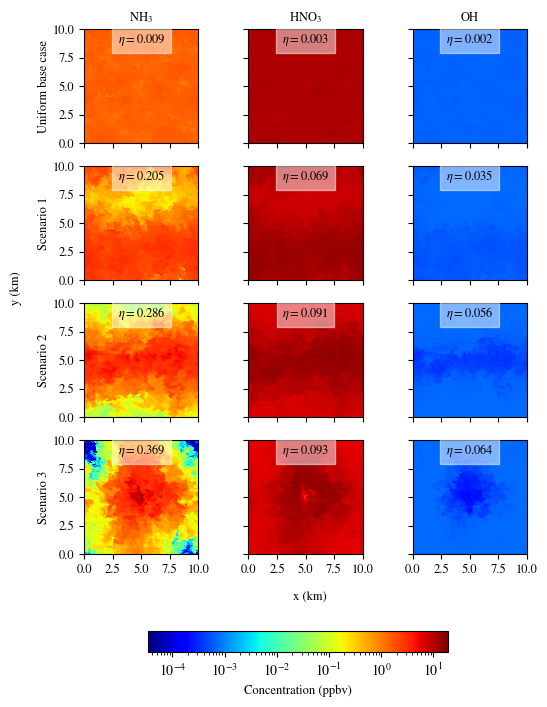

In [7]:
t = 36
z = 45
variables = ['nh3', 'hno3', 'oh']
scenarios = ['uniform-basecase', 'scenario-1', 'scenario-2', 'scenario-3']

plotCrossSections(Cat1, scenarios, variables, t, z, var_type='gas', savefig=False)


Sulfate is able to enter and stay in the aerosol phase but ammonium and nitrate will equilibrate to gas phase outside of the emission plume core.

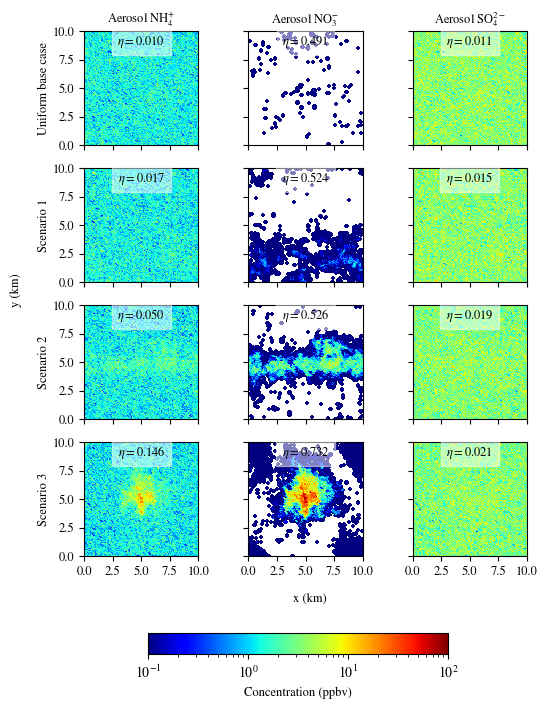

In [8]:
t = 36
z = 45
variables = ['pmc_NH4', 'pmc_NO3', 'pmc_SO4']
scenarios = ['uniform-basecase', 'scenario-1', 'scenario-2', 'scenario-3']

plotCrossSections(Cat1, scenarios, variables, t, z, var_type='aero', vmin=1e-1, vmax=1e2, savefig=False)

#### CCN profiles

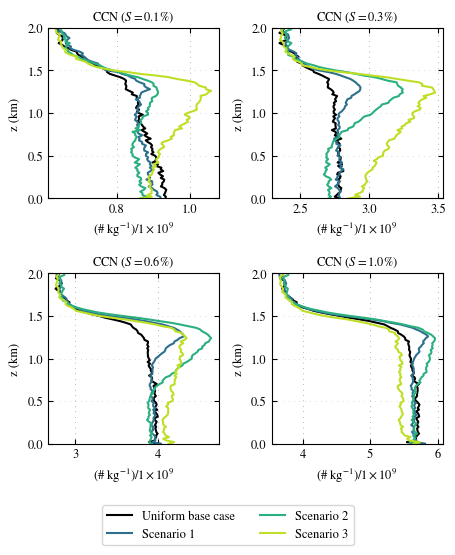

In [9]:
t=36
plotScenariosVarsVerticalProfile(DataStruct=Cat1, 
                                 scenarios=['uniform-basecase', 'scenario-1', 'scenario-2', 'scenario-3'], 
                                 variables=['ccn_001', 'ccn_003', 'ccn_006', 'ccn_010'], 
                                 unit_prefactor=1e-9,
                                 time=36, 
                                 general_scenario_label=True,
                                 use_standard_scenario_colors=True,
                                 title='',
                                 fig_xsize=4.66, fig_ysize=5.2,
                                 global_fontsize=9,
                                 grid_linewidth=0.6,
                                 legend_ncols=2,
                                 savefig=False,
                                 filename=f'aerosol-ccn-vertical-profiles-time{t}.pdf'
                                 )

#### CCN Profiles, no ammonia

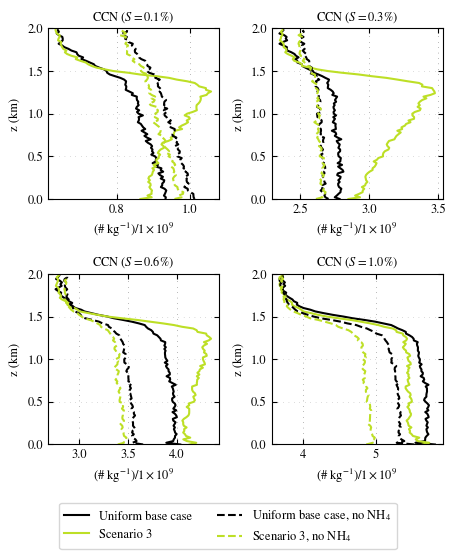

In [10]:
t=36
plotScenariosVarsVerticalProfile(DataStruct=Cat1, 
                                 scenarios=['uniform-basecase', 'scenario-3', 'uniform-basecase-no-nh4', 'scenario-3-no-nh4'
                                            ], variables=['ccn_001', 'ccn_003', 'ccn_006', 'ccn_010'
                                                                                          ], 
                                 time=36, 
                                 general_scenario_label=True,
                                 use_standard_scenario_colors=True,
                                 title='',
                                 unit_prefactor=1e-9,
                                 fig_xsize=4.66, fig_ysize=5.2,
                                 global_fontsize=9,
                                 grid_linewidth=0.6,
                                 legend_ncols=2,
                                 savefig=False,
                                 filename=f'aerosol-ccn-vertical-profiles-no-nh4-cases-time{t}.pdf'
                                 )

In [11]:
def plot_ScenarioDists(DataStruct, dist_type='num', k=25, t_idx=36, **kwargs):

    #global_fontsize = kwargs.get('global_fontsize', 9)
    # Configurable keyword arguments
    xlims = kwargs.get('xlims', (5e-9, 5e-6))
    if dist_type == 'num':
        ylims = kwargs.get('ylims', (1e7, 1e10))
        scaling_factor = 1 # keep as # m^-3
    if dist_type == 'mass':
        ylims = kwargs.get('ylims', (0, 1e-13))
        scaling_factor=1e9 # convert to micrograms per cubic meter
    yscale = kwargs.get('yscale', 'linear')
    savefig = kwargs.get('savefig', True)
    totconctimeidx=kwargs.get('totconctimeidx', DataStruct.n_times-1)
    lognorm = kwargs.get('lognorm', False)
    dist_cmap_name = kwargs.get('dist_cmap', 'viridis')
    dist_cmap = plt.get_cmap(dist_cmap_name)
    dist_cmap_normrange = kwargs.get('dist_cmap_norm_range', (0.2, 0.9))
    title_size = kwargs.get('title_size', 10)
    label_size = kwargs.get('label_size', 9)
    local_binning = kwargs.get('local_binning', None)
    legend_loc = kwargs.get('legend_loc', 'upper left')
    legend_ncol = kwargs.get('legend_ncol', 2)
    linewidth = kwargs.get('line_width', 1.5)
    write_legend_labels = kwargs.get('write_legend_labels', False)

    tot_conc_label = kwargs.get('field_var', f'TOT_{dist_type.upper()}_CONC')
    tot_conc_title = kwargs.get('field_title', None)

    dist_ij_loc = {'uniform-basecase': [50, 50],
               'scenario-1': [50, 25], # 25
               'scenario-2': [50, 50],
               'scenario-3': [50, 50],
    } 

    if kwargs.get('ax', None):
        ax = kwargs['ax']
    else:  
        fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
    
    # plot initial condition
    scenario_distdata = DataStruct.aerodist_data['uniform-basecase']

    # number of vertical levels in dataset
    n_k = scenario_distdata.dimensions['bottom_top'].size
    # for slices of datasets with one vertical level, ensure that the vertical level 
    # adheres to the zeroth index
    if (n_k == 1) and k > 0:
        k = 0
    
    x_vals = []
    bin_vals = []
    bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    t0 = 0
    i, j = dist_ij_loc['uniform-basecase']
    for bin_idx in range(100):
        bin_idx += 1 # 1 indexing 
        bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][t0, k, j, i].data.item()#/1e6
        if local_binning:
            bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][t0, k, j-local_binning:j+local_binning, i-local_binning:i+local_binning].data#/1e6
            bin_data = bin_data.mean()
        bin_vals.append(bin_data)
        x_vals.append(bin_idx)

    if write_legend_labels:
        label = 'Initial Condition'
    else:
        label = None
    ax.plot(scenario_distdata['BIN_CENTERS'][:].data[0], scaling_factor*np.array(bin_vals), 
            label=label, c='k', ls='--', lw=linewidth)

        
    colors = DataStruct.getScenarioColors()
    labels = DataStruct.getScenarioGeneralLabels()

    ultrafine_total_conc = {scenario: 0 for scenario in dist_ij_loc}
    accum_total_conc = {scenario: 0 for scenario in dist_ij_loc}
    # get the index of the bin that is the largest less than 50 nm
    cutoff_bin_idx = np.argwhere(scenario_distdata['BIN_EDGES'][0, :] < 5e-8)[-1][0]

    for scenario in dist_ij_loc:
        scenario_distdata = DataStruct.aerodist_data[scenario]
        i, j = dist_ij_loc[scenario]
        c = colors[scenario]
        
        x_vals = []
        bin_vals = []

        bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]
        bin_width = bin_edges[1:] - bin_edges[:-1]

        for bin_idx in range(100):
            bin_idx += 1 # 1 indexing 
            bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][t_idx, k, j, i].data.item()#/1e6
            if local_binning:
                bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][t_idx, k, j-local_binning:j+local_binning, i-local_binning:i+local_binning].data#/1e6
                bin_data = bin_data.mean()
            bin_vals.append(bin_data)
            x_vals.append(bin_idx)

            # sum up the total concentration in the ultrafine and accumulation modes
            if bin_idx <= cutoff_bin_idx:
                ultrafine_total_conc[scenario] += bin_data*bin_width[bin_idx-1]
            else:
                accum_total_conc[scenario] += bin_data*bin_width[bin_idx-1]

        if write_legend_labels:
            label = labels[scenario]
        else:
            label = None
        ax.plot(scenario_distdata['BIN_CENTERS'][:].data[0], scaling_factor*np.array(bin_vals), 
                label=label, c=c, lw=linewidth)

        # print out the percent change in Aitken/accumulation total concentration for each scenario relative to the basecase
        if scenario != 'uniform-basecase':
            basecase_ultrafine_conc = ultrafine_total_conc['uniform-basecase']
            basecase_accum_conc = accum_total_conc['uniform-basecase']

            scenario_ultrafine_pcnt_change = 100*(ultrafine_total_conc[scenario] - basecase_ultrafine_conc)/basecase_ultrafine_conc
            scenario_accum_pcnt_change = 100*(accum_total_conc[scenario] - basecase_accum_conc)/basecase_accum_conc

            print(f'{scenario} ultrafine total conc % change: {scenario_ultrafine_pcnt_change:3.2f}')
            print(f'{scenario} accumulation total conc % change: {scenario_accum_pcnt_change:3.2f}\n')
            #print(f'{scenario} ultrafine total conc: {ultrafine_total_conc[scenario]}')
            #print(f'{scenario} accumulation total conc: {accum_total_conc[scenario]}')
        
    ax.set_xscale('log')

    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ylims = ax.get_ylim()
    if yscale == 'log':
        ax.set_yscale('log')

    #ax.legend(loc=legend_loc, handlelength=1, ncol=legend_ncol, columnspacing=0.8)

    if dist_type == 'num':
        ax.set_ylabel('Number concentration (m$^{-3}$)', fontsize=label_size)
        #ax.set_title(f'Number distribution', fontsize=title_size)
    if dist_type == 'mass':
        ax.set_ylabel('Mass concentration ($\mu$g m$^{-3}$)', fontsize=label_size)
        #ax.set_title(f'Mass distribution', fontsize=title_size)

    ax.set_xlabel('Diameter (m)', fontsize=label_size)

    lw = kwargs.get('grid_linewidth', .7)
    ax.grid(which = "major", linewidth = lw, axis='y', ls="dashed", dashes=(4,4), c='#414141', alpha=.5)
    ax.grid(which = "minor", linewidth = lw, axis='y', ls="dashed", dashes=(6,6), c='white')
    ax.grid(which = "minor", linewidth = lw, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.grid(which = "major", linewidth = lw, axis='x', ls="dotted", dashes=(.5,6), c='#414141')
    ax.tick_params(axis='both', labelsize=label_size, which='major', direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    if kwargs.get('return_ax', False):
        return ax
    
    if savefig:
        plt.savefig(f'combined_{dist_type}conc_i{i}_j{j}_k{k}.pdf', format='pdf', bbox_inches='tight')
    plt.show()


Number concentration:
scenario-1 ultrafine total conc % change: 7.61
scenario-1 accumulation total conc % change: 24.06

scenario-2 ultrafine total conc % change: -27.17
scenario-2 accumulation total conc % change: 56.70

scenario-3 ultrafine total conc % change: -80.62
scenario-3 accumulation total conc % change: 245.65


Mass concentration:
scenario-1 ultrafine total conc % change: 24.56
scenario-1 accumulation total conc % change: 21.36

scenario-2 ultrafine total conc % change: -3.24
scenario-2 accumulation total conc % change: 50.75

scenario-3 ultrafine total conc % change: -73.49
scenario-3 accumulation total conc % change: 309.21



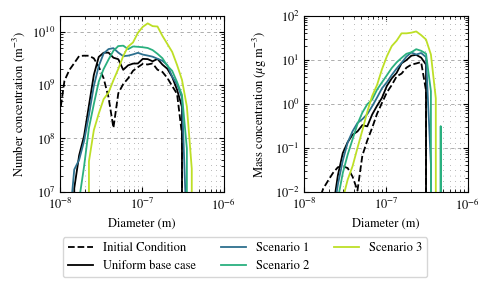

In [12]:
fig, axs = plt.subplots(1,2 , figsize=(5, 2.5))
print('Number concentration:')
axs[0] = plot_ScenarioDists(DataStruct=Cat2, dist_type='num', k=60, t_idx=1, # actually 36 in the original dataset
                            local_binning=10, ylims=(1e7, 2e10), xlims=(1e-8, 1e-6), yscale='log',
                            legend_ncol=1, legend_loc='upper right', label_size=9, 
                            line_width=1.3, grid_linewidth=.6, ax=axs[0], write_legend_labels=False, 
                            return_ax=True, savefig=False)

print('\nMass concentration:')
axs[1] = plot_ScenarioDists(DataStruct=Cat2, dist_type='mass', k=60, t_idx=1, # actually 36 in the original dataset
                            local_binning=10, ylims=(1e-2, 1e2), xlims=(1e-8, 1e-6), yscale='log',
                            legend_ncol=1, legend_loc='upper right', label_size=9, line_width=1.3, 
                            grid_linewidth=.6, ax=axs[1], return_ax=True, write_legend_labels=True, savefig=False)

plt.tight_layout()
fig.legend(fontsize=9, ncol=3, loc='center', bbox_to_anchor=(.5,-.05))

#plt.savefig(f'combined_num_mass_conc_i50_j50_k60.pdf', format='pdf', bbox_inches='tight')


In [13]:
def _getXTickTimes(DataStruct, xtick_units, xtick_delta, shift_tickloc=False):
    history_delta = DataStruct.historydelta_m
    total_duration = (DataStruct.n_times-1)*history_delta

    if xtick_units != 'm' and xtick_units != 'h':
        raise ValueError(f'Invalid label for xtick_units: {xtick_units}')
    elif xtick_units == 'h':
        total_duration = total_duration/60
        history_delta = history_delta/60

    n_xticks = int(1 + total_duration / xtick_delta)
    xtick_nudge = 0.5
    if not shift_tickloc:
        xtick_nudge = 0
    xticks = xtick_nudge + np.linspace(0, DataStruct.n_times-1, n_xticks) # shift by 1/2 to be cell-centered
    xtick_labels = history_delta*np.linspace(0, DataStruct.n_times-1, n_xticks)
    xtick_labels = xtick_labels.astype(int)

    return xticks, xtick_labels

def _createSuperSatLabel(variable):
    supersat = int(variable.split('_')[1])/10
    label = f'$S = {supersat}\%$'
    return label

def _plotContours(ZT_data, ax, **kwargs):
    contour_smoothing = kwargs.get('smooth_contours', False)
    smoothing_sigma = kwargs.get('contour_smoothing_sigma', 0.7)
    contour_linewidth = kwargs.get('contour_linewidth', 1.5)
    contour_label_fontsize = kwargs.get('contour_label_fontsize', 9)
    contourmax = kwargs.get('contour_max', 15)
    contourmin = kwargs.get('contour_min', -15)
    ncontours = kwargs.get('n_contours', 9)
    contour_levels = kwargs.get('contour_levels', [x for x in np.linspace(contourmin,contourmax, ncontours) if x!= 0])
    contour_norm = kwargs.get('contour_norm', mplcolors.Normalize(contourmin, contourmax))
    fmt = kwargs.get('contour_fmt', matplotlib.ticker.ScalarFormatter())
    fmt.create_dummy_axis()
    # for whatever reason, the bounds for the countours are one cell off, so the contours on the 
    # rhs of plots was getting cut off. Shifting values to the right (one timestep) and copy paste
    # entries for the intiial condition into a new array with dimension (nlevels, ntimes+1)
    zt1 = ZT_data.T
    shift=kwargs.get('shift', 1)
    zt2 = np.zeros((zt1.shape[0], zt1.shape[1]+shift))
    zt2[:, shift:] = zt1[:, :]
    for i in range(shift):
        zt2[:, i] = zt1[:, i]

    if contour_smoothing:
        zt2 = gaussian_filter(zt2, smoothing_sigma)

    #CS = ax.contour(ZT_data.T, levels=contour_levels, cmap=kwargs.get('contour_cmap', 'gist_gray_r'))
    CS = ax.contour(zt2, levels=contour_levels, cmap=kwargs.get('contour_cmap', 'gist_gray_r'), 
                    norm=contour_norm, linewidths=contour_linewidth)
    ax.clabel(CS, inline=True, fontsize=contour_label_fontsize, fmt=fmt)


In [14]:
def plotMultiScenarioCCNPercentDiff(DataStruct, vmin=None, vmax=None,  skip_t0=False, **kwargs):

    fig_xsize = kwargs.get('fig_xsize', 7)
    fig_ysize = kwargs.get('fig_ysize', 3)
    fig, axs  = plt.subplots(4,3, figsize=(fig_xsize, fig_ysize), sharex=True, sharey=True, layout='constrained')

    global_fontsize = kwargs.get('global_fontsize', 9)

    general_scenario_labels = DataStruct.getScenarioGeneralLabels()

    vars = ['ccn_001', 'ccn_003', 'ccn_006', 'ccn_010']
    scenarios = ['scenario-1', 'scenario-2', 'scenario-3']*4
    for i, (scenario, ax) in enumerate(zip(scenarios, axs.flatten())):
        if i % 3 == 0:
            variable = vars[i//3]

        ub_data = DataStruct.aero_data['uniform-basecase'][variable][:]
        scenario_data = DataStruct.aero_data[scenario][variable][:]      
        rel_diff = 100*(scenario_data - ub_data)/(ub_data)

        cs = ax.pcolormesh(rel_diff.T, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax,edgecolor='face')

        if i==0:
            cbar = fig.colorbar(cs, ax=axs, orientation='horizontal', fraction=0.04, pad=0.05
                                )

            cbar_title = kwargs.get('cbar_title', '% difference')   
            cbar.set_label(label=cbar_title, fontsize=global_fontsize)
            cbar.ax.tick_params(labelsize=global_fontsize)

        if kwargs.get("plot_contours"):
            _plotContours(rel_diff, ax, **kwargs)

        variable_fmt = variable
        if variable in DataStruct.aero_vars:
            variable_fmt = DataStruct.aerosol_fmt_map[variable]
        if variable in DataStruct.gas_vars:
            variable_fmt = DataStruct.gas_fmt_map[variable]

        # Set x-axis ticks and labels   
        xtick_units = kwargs.get('xtick_units', 'm') 
        xtick_delta = kwargs.get('xtick_delta_t', 30)
        xticks, xtick_labels = _getXTickTimes(DataStruct, xtick_units, xtick_delta, shift_tickloc=True)
        ax.set_xticks(xticks)
        if i < 9:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(xtick_labels)
            ax.set_xlabel(f'Time ({xtick_units})', fontsize=global_fontsize)

        # Set y-axis ticks and labels
        ax.set_yticks(np.arange(0, DataStruct.n_levels+1, 25))
        ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
        if i%3 == 0:
            ax.set_ylabel('z (km)', fontsize=global_fontsize)

            # add text 
            label = _createSuperSatLabel(variable)
            ax.text(x=-.6, y=.5, s=label, transform=ax.transAxes)

        ax.tick_params(axis='both', which='major', labelsize=global_fontsize)

        if i < 3:
            ax.set_title(general_scenario_labels[scenario], fontsize=global_fontsize)

    if kwargs.get("savefig"):
        plt.savefig(f'height-time-ccn-pdiff-multi-scenario.pdf', format='pdf', bbox_inches='tight')

In [15]:
# The domain extent is automatically inferred from the netcdf file
# overwriting values with hard-coded extents since the category 3 
# datasets average over x and y (so both are 1)
Cat3.domain_x_cells = 100
Cat3.domain_y_cells = 100

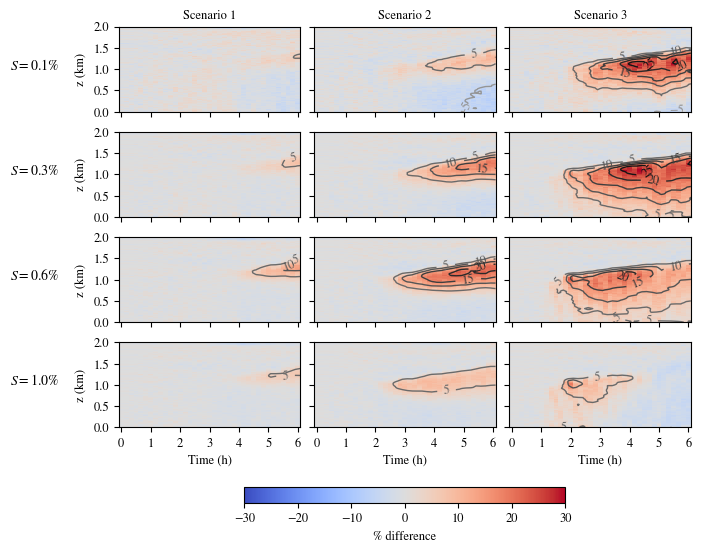

In [16]:
vmin = -30
vmax = 30
# smoothing sigma previously set to 0.6
plotMultiScenarioCCNPercentDiff(DataStruct=Cat3, vmin=vmin, vmax=vmax,  fig_xsize=6.9, fig_ysize=5.42, #plot_significance=True,
                   plot_contours=True, n_contours=13, contour_min=-30, contour_max=30, contour_label_fontsize=9, 
                   smooth_contours=True, contour_smoothing_sigma=.8, contour_linewidth=1,
                   xtick_delta_t=1, xtick_units='h',
                   savefig=False
                   )

/var/folders/3p/g6j_y4hj63v0_klskdgcx7jm0000gr/T/ipykernel_89348/2240008696.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


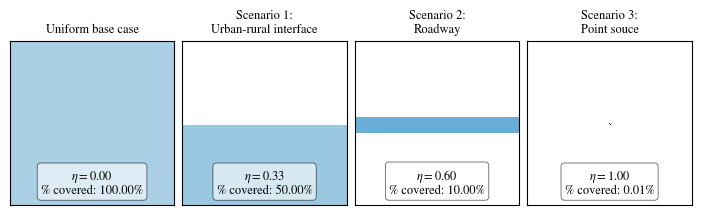

In [19]:
domain_x_cells = 100
domain_y_cells = 100

spatial_het_dir = os.path.join(os.getcwd(), '..', 'data', 'spatial-het')
sh_dataset = pd.read_csv(f'{spatial_het_dir}/sh_patterns_xres{domain_x_cells}_yres{domain_y_cells}_exact.csv', header=0)

shdir = 'sh-patterns'
griddir = f'xres{domain_x_cells}yres{domain_y_cells}'

fig, axs = plt.subplots(1, 4, figsize=(6.9, 3), layout='constrained')
cmap = plt.cm.get_cmap('Blues')
cmap.set_bad('white')#'#dedede')

analysis_scenarios = ['uniform-basecase', 'scenario-1', 
                      'scenario-2','scenario-3'
                     ]

scenario_fmt_names = ['Uniform base case', 'Scenario 1:\nUrban-rural interface', 'Scenario 2:\nRoadway', 'Scenario 3:\nPoint souce']

i = 1

for ax, scenario, scenario_fmt in zip(axs.flatten(), analysis_scenarios, scenario_fmt_names):
    nshval = sh_dataset[sh_dataset.scenario == scenario].NSH.values[0]
    ax.set_xticks([])
    ax.set_yticks([])
    filename = f'{scenario}.csv'
    array_path = os.path.join(spatial_het_dir, shdir, griddir, filename)
    scenario_arr = np.genfromtxt(array_path, delimiter=',')
    scaling_factor = sh_dataset[sh_dataset.scenario == scenario]["scaling-factor"].values[0]
    scenario_arr = scaling_factor*scenario_arr
    vmin=.01
    vmax=10000
    ax.pcolormesh(scenario_arr, norm=mplcolors.LogNorm(vmin, vmax), edgecolor='face',
                  #norm=mplcolors.Normalize(vmin,vmax),
                  cmap=cmap)
    meanval = scenario_arr.mean()
    variance = scenario_arr.std()**2

    if scenario == 'uniform-basecase':
        title_name = 'Uniform Base Case'
    else:
        title_name = f'Scenario {i}'
        i += 1
    ax.set_title(scenario_fmt, fontsize=9)
    ax.text(x=.5, y=.07, s=f'$\eta={nshval:3.2f}$\n% covered: {100/scaling_factor:3.2f}%',
            fontsize=9, linespacing=1,
            horizontalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=.6, boxstyle='round', lw=.6))
    #ax.text(x=.5, y=.07, s=f'$SH={nshval:3.2f}$\n$\overline{{f}}(S)={meanval:3.2f}$\n$\sigma^2={variance:3.2f}$',
    #        fontsize=7.5, linespacing=1,
    #        horizontalalignment='center', transform=ax.transAxes,
    #        bbox=dict(facecolor='white', alpha=.6, boxstyle='round', lw=.6))
    ax.set_aspect('equal', adjustable='box')
    
#plt.savefig(f'SH-scenarios.pdf', format='pdf', bbox_inches='tight')
